In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_excel('../data/DS_assessment.xlsx', sheet_name='Data')
df = df.rename(columns={'ID':'id',
                        'Age': 'age',
                        'Experience':'experience',
                        'Income':'income',
                        'Postal Code': 'postal_code',
                       'Family Size': 'family_size',
                        'CCAvgSpending':'creditc_avg_spent',
                        'Education':'education',
                        'Mortgage':'mortgage',
                       'Investment Account': 'investment_account',
                       'Deposit Account' : 'deposit_account',
                       'InternetBanking':'internet_banking',
                       'Personal Loan': 'personal_loan'})

In [3]:
df

,id,age,experience,income,postal_code,family_size,creditc_avg_spent,education,mortgage,investment_account,deposit_account,internet_banking,personal_loan
0,1,25,1,49.0,91107,4.0,1.6,Undergrad,0,1,0,NO,NO
1,2,45,19,34.0,90089,3.0,1.5,Undergrad,0,1,0,NO,NO
2,3,39,15,11.0,94720,1.0,1.0,Undergrad,0,0,0,NO,NO
3,4,35,9,NaN,94112,1.0,2.7,Graduate,0,0,0,NO,NO
4,5,35,8,45.0,91330,4.0,1.0,Graduate,0,0,0,NO,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40.0,92697,1.0,1.9,Advanced Degree,0,0,0,YES,NO
4996,4997,30,4,15.0,92037,4.0,0.4,Undergrad,85,0,0,YES,NO
4997,4998,63,39,24.0,93023,2.0,0.3,Advanced Degree,0,0,0,NO,NO
4998,4999,65,40,49.0,90034,3.0,0.5,Graduate,0,0,0,YES,NO


### Feature Selection

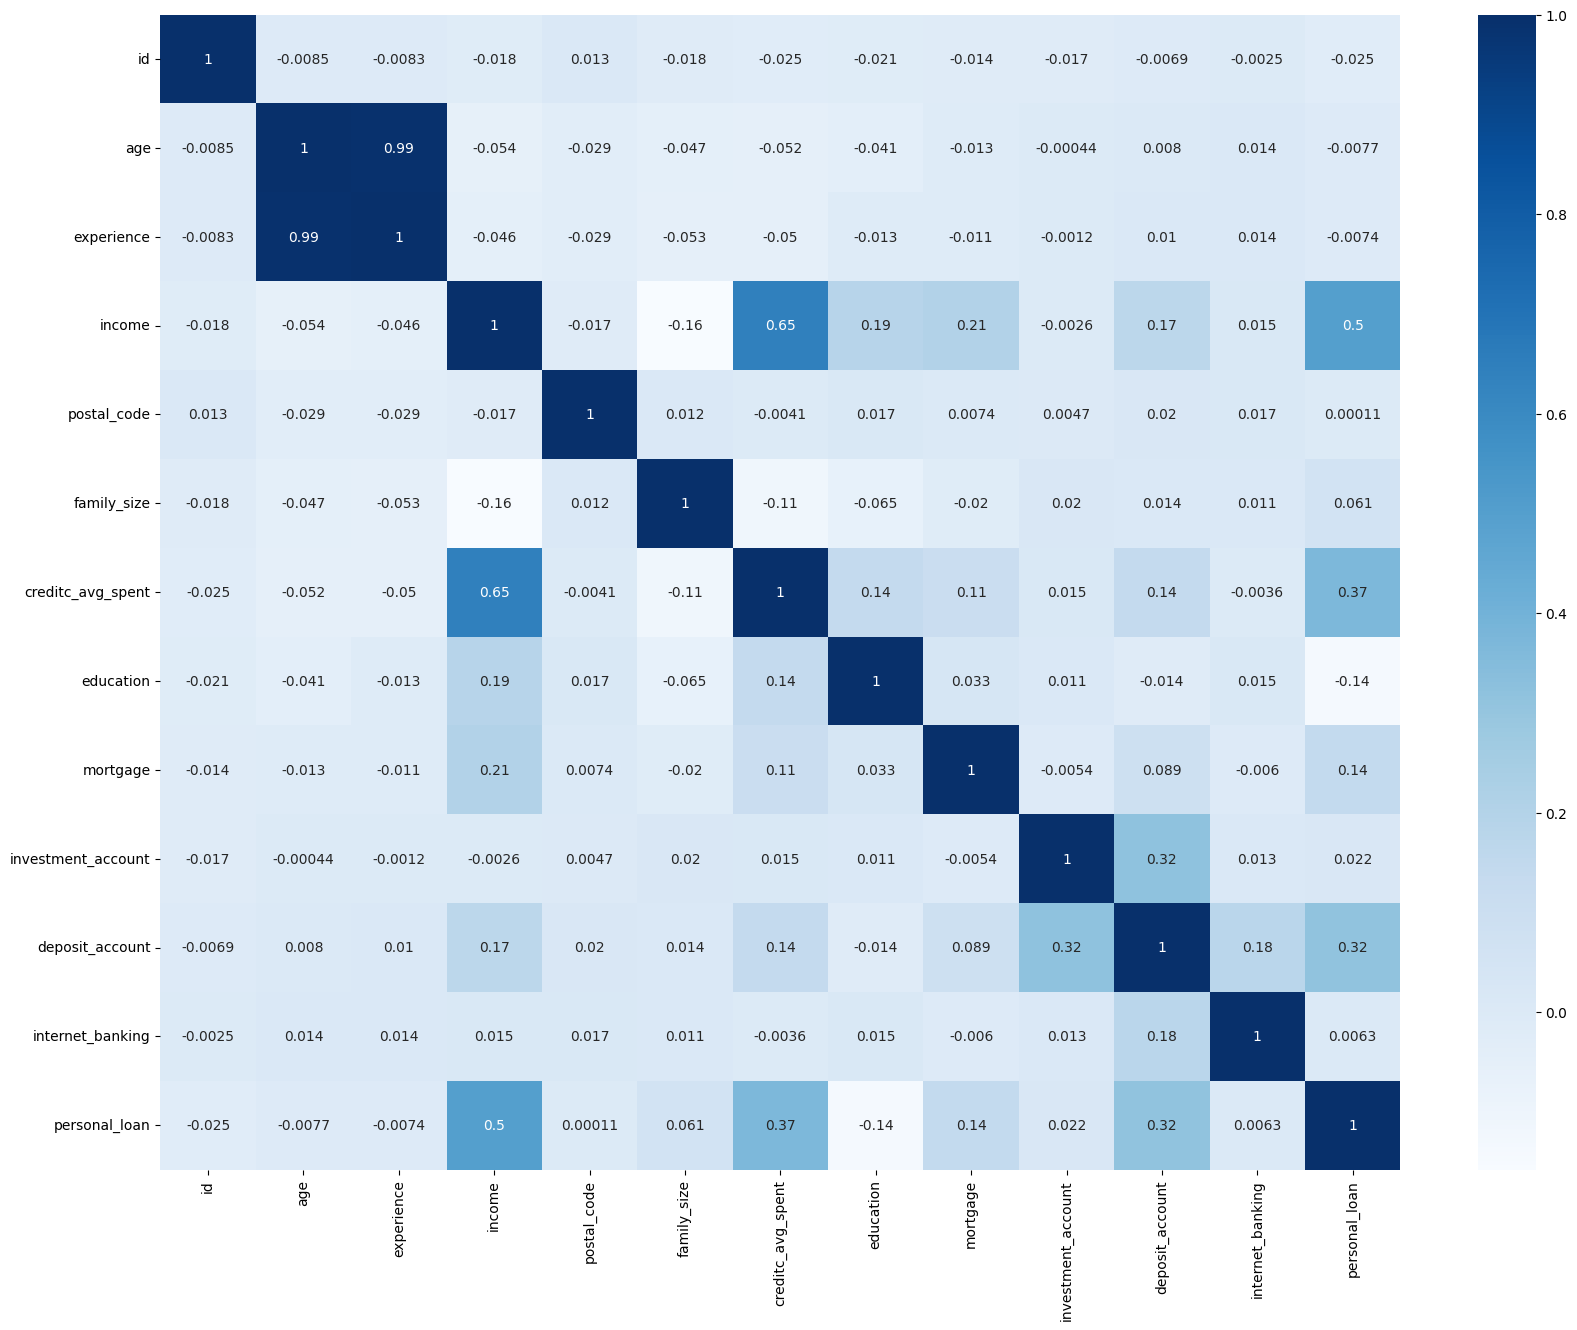

In [6]:
feat_df = df.copy()
ordinal = OrdinalEncoder()
feat_df['personal_loan'] = ordinal.fit_transform(df[['personal_loan']])
feat_df['internet_banking'] = ordinal.fit_transform(df[['internet_banking']])
feat_df['education'] = ordinal.fit_transform(df[['education']])

corr = feat_df.corr()
sns.heatmap(corr, cmap='Blues', annot=True)
plt.gcf().set_size_inches(20, 15)
plt.show()


## Age, experience, internet_banking and postal_code have little to no impact on the decision for personal_loan, so we ll drop them

In [7]:
cols_to_encode = ['education', 'investment_account']
cols_to_scale = ['income', 'family_size','creditc_avg_spent', 'mortgage']

In [8]:
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
                           ('ordinal', OrdinalEncoder())])
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
                           ('scalar', StandardScaler())])

In [9]:
preprocess = ColumnTransformer(
transformers=[
    ('num', num_transformer, cols_to_scale),
    ('cat', cat_transformer, cols_to_encode)
])

In [27]:
def data_split(df, smote=False):
    """
    This function takes dataframe and splits it into train
    test split along with option for  SMOTE oversampling 
    """
    y = df['personal_loan']
    X = df.drop(columns=['personal_loan', 'postal_code'])
    target_mapping = {'YES': 1, 'NO': 0}
    y = y.map(target_mapping)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    X_train = preprocess.fit_transform(X_train)
    X_test = preprocess.transform(X_test)
    
    if smote:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    return X_train, X_test, y_train, y_test 

In [28]:
preprocess = ColumnTransformer(
transformers=[
    ('num', num_transformer, cols_to_scale),
    ('cat', cat_transformer, cols_to_encode)
])


In [29]:
# List of different models 
models = {
                "Random Forest": RandomForestClassifier(),
                "Gradient Boosting": GradientBoostingClassifier(),
                "XGBClassifier": XGBClassifier(),
                "KNeighborsClassifier": KNeighborsClassifier(),
            }

# Define parameters for search for different models
params = {
    "Random Forest": {
        'n_estimators': [8, 16, 32, 64, 128, 256]
    },
    "Gradient Boosting": {
        'learning_rate': [.1, .01, .05, .001],
        'n_estimators': [8, 16, 32, 64, 128, 256],
    },
    "XGBClassifier": {
        'learning_rate': [.1, .01, .05, .001],
        'n_estimators': [8, 16, 32, 64, 128, 256]
    },
    "KNeighborsClassifier": {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }

}

In [30]:
def evaluate_models(X_train, y_train, X_test, y_test, models, param):
    """
    This function evaluates the model on detailed classification report for each class,
    ROC AUC Score and ROC Curve"""
    report = {}
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model_name = list(models.keys())[i]
        para = param[list(models.keys())[i]]
        gs = GridSearchCV(model, para, cv=5)
        gs.fit(X_train, y_train)

        model.set_params(**gs.best_params_)
        model.fit(X_train, y_train)

        y_test_pred = model.predict(X_test)

        test_model_score = roc_auc_score(y_test, y_test_pred)

        report[list(models.keys())[i]] = test_model_score

        print(f'Model Score for {model_name} is {model.score(X_test, y_test)}')
        print("============================================\n============================================")
        print('The classification report is:')
        print(classification_report(y_test, y_test_pred))
        # Load the predicted probabilities and true labels
        print("============================================\n============================================")
        # Compute the ROC AUC score
        roc_auc = roc_auc_score(y_test, y_test_pred)
        print(f'Model AUC Score is {roc_auc}')            
        # Compute the ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

        # Plot the ROC curve
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve')
        plt.legend(loc='lower right')
        plt.show()
        print("============================================\n============================================\n============================================")

    return report

Model Score for Random Forest is 0.99
The classification report is:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       904
           1       0.97      0.93      0.95        96

    accuracy                           0.99      1000
   macro avg       0.98      0.96      0.97      1000
weighted avg       0.99      0.99      0.99      1000

Model AUC Score is 0.9618823746312686


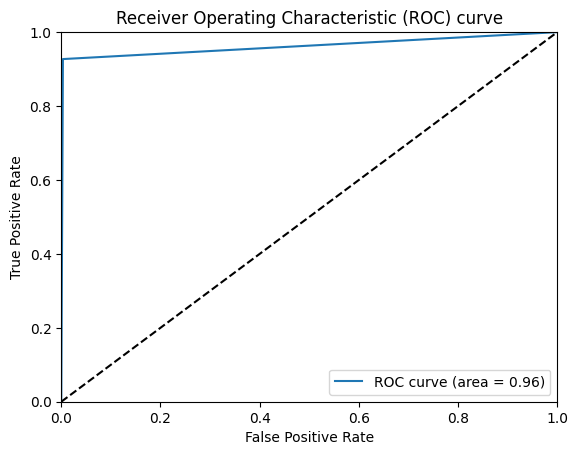

Model Score for Gradient Boosting is 0.988
The classification report is:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       904
           1       0.97      0.91      0.94        96

    accuracy                           0.99      1000
   macro avg       0.98      0.95      0.96      1000
weighted avg       0.99      0.99      0.99      1000

Model AUC Score is 0.9514657079646018


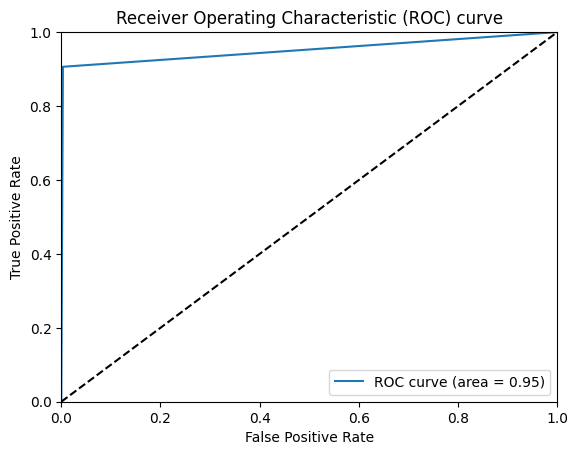

Model Score for XGBClassifier is 0.993
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       904
           1       0.97      0.96      0.96        96

    accuracy                           0.99      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.99      0.99      0.99      1000

Model AUC Score is 0.9775073746312686


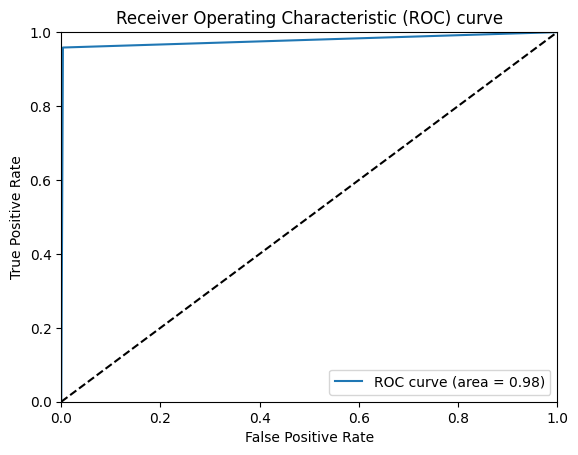

Model Score for KNeighborsClassifier is 0.978
The classification report is:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       904
           1       0.97      0.79      0.87        96

    accuracy                           0.98      1000
   macro avg       0.98      0.89      0.93      1000
weighted avg       0.98      0.98      0.98      1000

Model AUC Score is 0.8947271386430679


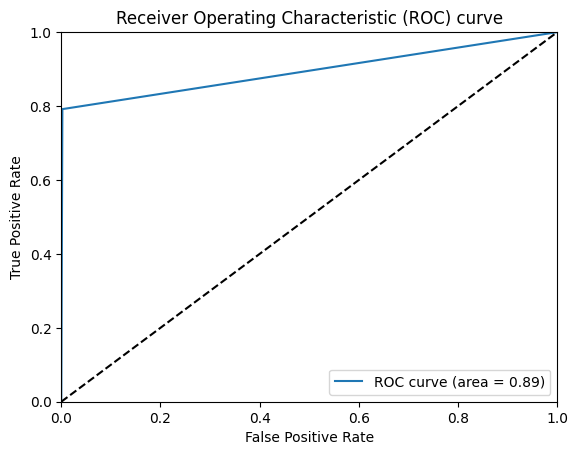

{'Random Forest': 0.9618823746312686,
 'Gradient Boosting': 0.9514657079646018,
 'XGBClassifier': 0.9775073746312686,
 'KNeighborsClassifier': 0.8947271386430679}

In [36]:
X_train, X_test, y_train, y_test = data_split(df)
report = evaluate_models(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                                                 models=models, param=params)
report

Model Score for Random Forest is 0.986
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       904
           1       0.95      0.91      0.93        96

    accuracy                           0.99      1000
   macro avg       0.97      0.95      0.96      1000
weighted avg       0.99      0.99      0.99      1000

Model AUC Score is 0.9503595132743362


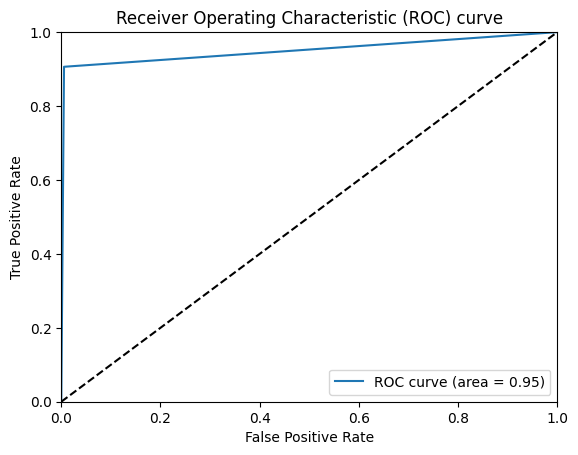

Model Score for Gradient Boosting is 0.99
The classification report is:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       904
           1       0.96      0.94      0.95        96

    accuracy                           0.99      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.99      0.99      0.99      1000

Model AUC Score is 0.9665376106194691


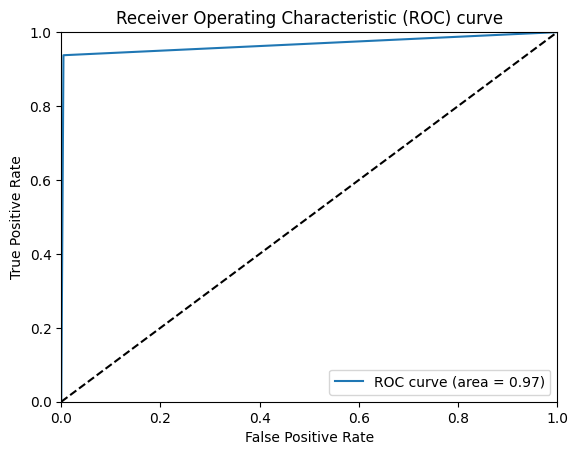

Model Score for XGBClassifier is 0.987
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       904
           1       0.95      0.92      0.93        96

    accuracy                           0.99      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.99      0.99      0.99      1000

Model AUC Score is 0.9555678466076695


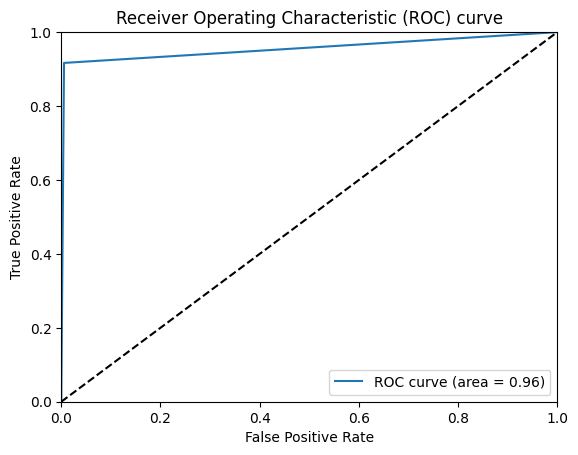

Model Score for KNeighborsClassifier is 0.978
The classification report is:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       904
           1       0.94      0.82      0.88        96

    accuracy                           0.98      1000
   macro avg       0.96      0.91      0.93      1000
weighted avg       0.98      0.98      0.98      1000

Model AUC Score is 0.9086928466076695


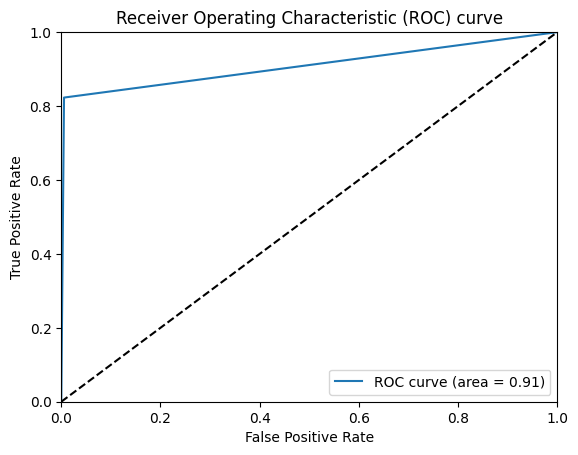

{'Random Forest': 0.9503595132743362,
 'Gradient Boosting': 0.9665376106194691,
 'XGBClassifier': 0.9555678466076695,
 'KNeighborsClassifier': 0.9086928466076695}

In [39]:
X_train, X_test, y_train, y_test = data_split(df, smote=True)
report = evaluate_models(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                                                 models=models, param=params)
report